<h3>Importing all required libraries</h3>

In [1]:
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

<h3>Loading the dataset</h3>

In [2]:
data=pd.read_csv('flipkart_com.csv')

<h3>Data Preprocessing</h3>
<h4>Converting the required tables in lower cases and removing the brackets and quotes</h4>

In [3]:
data["description"]=data["description"].str.lower()
data["product_category_tree"]=data["product_category_tree"].str.lower()
data["product_category_tree"]=data["product_category_tree"].str.replace('[', '')
data["product_category_tree"]=data["product_category_tree"].str.replace(']', '')
data["product_category_tree"]=data["product_category_tree"].str.replace('"', '')
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"clothing >> women's clothing >> lingerie, slee...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,key features of alisha solid women's cycling s...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,furniture >> living room furniture >> sofa bed...,SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,fabhomedecor fabric double sofa bed (finish co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,footwear >> women's footwear >> ballerinas >> ...,SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,key features of aw bellies sandals wedges heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"clothing >> women's clothing >> lingerie, slee...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,key features of alisha solid women's cycling s...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,pet supplies >> grooming >> skin & coat care >...,PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,specifications of sicons all purpose arnica do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


<h4>Splitting the product category column</h4>

In [4]:
data.dropna(inplace = True)
new = data["product_category_tree"].str.split(">>", n = 5, expand = True)
data["primary_category"]= new[0]
data["category1"]= new[1]
data["category2"]= new[2]
data["category3"]= new[3]
data["category4"]= new[4]
data.drop(columns =["product_category_tree"], inplace = True)

<h4>Created functions for removing punctuations, removing simple english words ,  Lemmatizing and Stemming</h4>

In [5]:
def remove_punc(text):
    st="".join([a for a in text if a not in string.punctuation])
    return st

def remove_simplewords(text):
    words=[w for w in text if not w in stopwords.words('english')]
    return words

def word_lem(text):
    txt=[lemmatizer.lemmatize(i) for i in text]
    return txt

def word_stem(text):
    txt=" ".join([stemm.stem(i) for i in text])
    return txt

In [6]:
#Removing punctuations from product description
data['description']=data['description'].apply(lambda x:remove_punc(x))

<h3>Tokenization</h3>
This breaks up the strings into a list of words or pieces based on a specified pattern using Regular Expressions aka RegEx. The pattern I chose to use this time (r'\w') also removes punctuation and is a better option for this data in particular.

In [7]:
tokenizer=RegexpTokenizer(r'\w+')
data['description']=data['description'].apply(lambda x:tokenizer.tokenize(x))
data['description']

0        [key, features, of, alisha, solid, womens, cyc...
1        [fabhomedecor, fabric, double, sofa, bed, fini...
2        [key, features, of, aw, bellies, sandals, wedg...
3        [key, features, of, alisha, solid, womens, cyc...
4        [specifications, of, sicons, all, purpose, arn...
                               ...                        
19995    [buy, walldesign, small, vinyl, sticker, for, ...
19996    [buy, wallmantra, large, vinyl, stickers, stic...
19997    [buy, elite, collection, medium, acrylic, stic...
19998    [buy, elite, collection, medium, acrylic, stic...
19999    [buy, elite, collection, medium, acrylic, stic...
Name: description, Length: 14058, dtype: object

In [8]:
#Removing simple english words like 'i','me','myself' as they don't play an important role in prediction
data['description']=data['description'].apply(lambda x:remove_simplewords(x))
data['description']

0        [key, features, alisha, solid, womens, cycling...
1        [fabhomedecor, fabric, double, sofa, bed, fini...
2        [key, features, aw, bellies, sandals, wedges, ...
3        [key, features, alisha, solid, womens, cycling...
4        [specifications, sicons, purpose, arnica, dog,...
                               ...                        
19995    [buy, walldesign, small, vinyl, sticker, rs730...
19996    [buy, wallmantra, large, vinyl, stickers, stic...
19997    [buy, elite, collection, medium, acrylic, stic...
19998    [buy, elite, collection, medium, acrylic, stic...
19999    [buy, elite, collection, medium, acrylic, stic...
Name: description, Length: 14058, dtype: object

<h3>Lemmatizing</h3>
Lemmatizing maps common words into one base.It always
returns a proper word that can be found in the dictionary.


In [9]:
lemmatizer = WordNetLemmatizer()
data["description"].apply(lambda z : word_lem(z))
data['description']

0        [key, features, alisha, solid, womens, cycling...
1        [fabhomedecor, fabric, double, sofa, bed, fini...
2        [key, features, aw, bellies, sandals, wedges, ...
3        [key, features, alisha, solid, womens, cycling...
4        [specifications, sicons, purpose, arnica, dog,...
                               ...                        
19995    [buy, walldesign, small, vinyl, sticker, rs730...
19996    [buy, wallmantra, large, vinyl, stickers, stic...
19997    [buy, elite, collection, medium, acrylic, stic...
19998    [buy, elite, collection, medium, acrylic, stic...
19999    [buy, elite, collection, medium, acrylic, stic...
Name: description, Length: 14058, dtype: object

<h3>Stemming</h3>
Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma.

In [10]:
stemm=PorterStemmer()
data["description"]=data["description"].apply(lambda z:word_stem(z))
data['description']

0        key featur alisha solid women cycl short cotto...
1        fabhomedecor fabric doubl sofa bed finish colo...
2        key featur aw belli sandal wedg heel casualsaw...
3        key featur alisha solid women cycl short cotto...
4        specif sicon purpos arnica dog shampoo 500 ml ...
                               ...                        
19995    buy walldesign small vinyl sticker rs730 onlin...
19996    buy wallmantra larg vinyl sticker sticker rs11...
19997    buy elit collect medium acryl sticker rs999 on...
19998    buy elit collect medium acryl sticker rs1199 o...
19999    buy elit collect medium acryl sticker rs999 on...
Name: description, Length: 14058, dtype: object

<h3>Data Analysis</h3>

In [11]:
#Independent variable which contains the product description
X=data.iloc[:,9]
X

0        key featur alisha solid women cycl short cotto...
1        fabhomedecor fabric doubl sofa bed finish colo...
2        key featur aw belli sandal wedg heel casualsaw...
3        key featur alisha solid women cycl short cotto...
4        specif sicon purpos arnica dog shampoo 500 ml ...
                               ...                        
19995    buy walldesign small vinyl sticker rs730 onlin...
19996    buy wallmantra larg vinyl sticker sticker rs11...
19997    buy elit collect medium acryl sticker rs999 on...
19998    buy elit collect medium acryl sticker rs1199 o...
19999    buy elit collect medium acryl sticker rs999 on...
Name: description, Length: 14058, dtype: object

In [12]:
#Dependent variable which is the product
Y=data.iloc[:,14].values
Y

array(['clothing ', 'furniture ', 'footwear ', ..., 'baby care ',
       'baby care ', 'baby care '], dtype=object)

In [13]:
#Splitting the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

<h3>Naive bayes</h3>
Naive bayes is a supervised learning algorithm for classification so the task is to find the class of observation (data point) given the values of features. Naive bayes classifier calculates the probability of a class given a set of feature values (i.e. p(yi | x1, x2 , … , xn)).

In [14]:
#creating a pipeline to assemble steps which are countvectorization , tfid transformer and then the naive bayes class
nb = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(x_train,y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [15]:
#predicting the test set data
y_pred=nb.predict(x_test)

In [16]:
#accuracy
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.8018018018018018


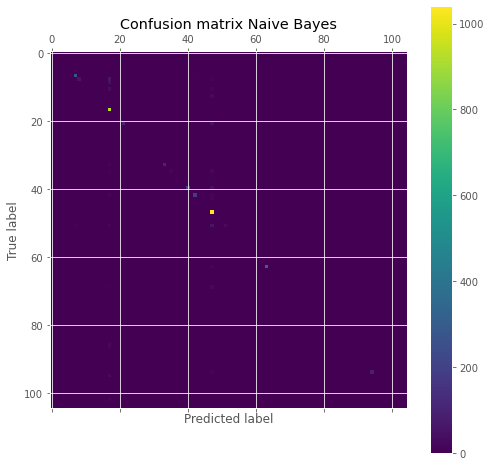

In [17]:
#confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plt.matshow(cm)
plt.colorbar()
plt.title('Confusion matrix Naive Bayes')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.gcf().set_size_inches(8, 8)
plt.show()

<h3>Support Vector Machines(SVM)</h3>
A support vector machine (SVM) is a supervised machine learning model that uses classification algorithms for two-group classification problems. After giving an SVM model sets of labeled training data for each category, they're able to categorize new text.

In [22]:
#creating a pipeline to assemble steps which are countvectorization , tfid transformer and then the SVM class
na = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
               ('svc', SVC(kernel='linear',gamma='auto')),
              ])
na.fit(x_train,y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('svc', SVC(gamma='auto', kernel='linear'))])

In [23]:
#predicting the test set data
y_pred1=na.predict(x_test)

In [24]:
#Accuracy
print('accuracy %s' % accuracy_score(y_pred1, y_test))

accuracy 0.9542437174016122


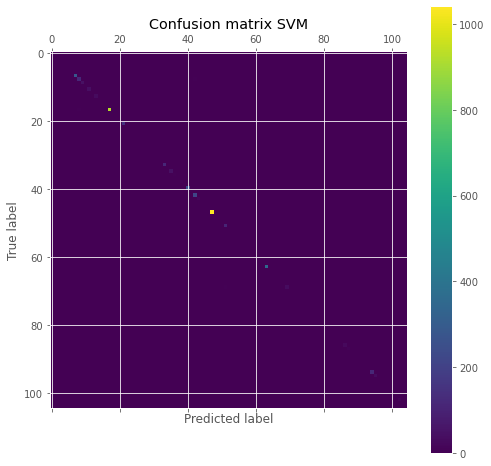

In [25]:
#Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred1)
plt.matshow(cm)
plt.colorbar()
plt.title('Confusion matrix SVM')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.gcf().set_size_inches(8, 8)
plt.show()

<h3>Conclusion</h3>
SVM classifier is more suitable than the naive bayes classifier for this dataset